In [85]:
# Import basic libraries
import os
import pandas as pd

# Sklearn libraries
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [86]:
# directories
current_dir = os.getcwd()
csv_folder = 'data'
acq_data_folder = 'data'

In [87]:
## reading data

# from csv's
train_csv = pd.read_csv(os.path.join(current_dir,csv_folder,'train.csv')).set_index('game_id')
test_csv = pd.read_csv(os.path.join(current_dir,csv_folder,'test.csv')).set_index('game_id')

# from scraping
scrape_csv = pd.read_csv(os.path.join(current_dir,acq_data_folder,'df_website.csv'))

# from API
api_csv = pd.read_csv(os.path.join(current_dir,acq_data_folder,'api_df_working_dist.csv'))

# from SQL
sql_csv = pd.read_csv(os.path.join(current_dir,acq_data_folder,'sql_blue_x_red_diff.csv'),sep=';')

In [88]:
# short display of data
train_csv.head(5)

,Year,Season,blueTeamTag,bResult,redTeamTag,gamelength
game_id,,,,,,
b96f782c-da04-4641-9306-68968036bfd9,2016,Summer,TT,1,HWA,50
2a7e2cb1-5ac2-4ea2-bd18-0b261e43345a,2016,Summer,CRW,0,HWA,31
e04ed84d-929b-4f0e-a769-e7bffc2b5162,2016,Summer,SUP,1,AUR,50
8829614a-313e-413c-9520-d95d7b95af31,2016,Spring,JAG,1,SSB,40
db2cf98d-a55e-4e28-9702-d7363fad2ebb,2016,Spring,SIN,0,CHF,36


In [89]:
def tidy_up_gold_df(df):
    df = df.copy()\
           .pivot(index=['game_id'], columns='Type')\
           .astype(int) 
    return df

def gold_lead_blue(df):
    # define teams
    blue_players = ['goldblueTop','goldblueJungle','goldblueMiddle','goldblueADC','goldblueSupport']
    red_players = ['goldredTop','goldredJungle','goldredMiddle','goldredADC','goldredSupport']

    # aggregate team gold
    blue_gold = df['min_10'][blue_players]\
                    .astype(int)\
                    .sum(axis=1)
    
    red_gold= df['min_10'][red_players]\
                    .astype(int)\
                    .sum(axis=1)
    
    # return team difference
    gold_lead_blue = pd.DataFrame(blue_gold-red_gold,columns=['value'])
    return gold_lead_blue

gold_lead_blue = scrape_csv.pipe(tidy_up_gold_df).pipe(gold_lead_blue)

In [90]:
gold_lead_blue

,value
game_id,
0001c4f2-b421-41e7-ae5e-6e8a61c7ad26,-1805
00032e36-8a18-472c-bf38-61b836b72e45,1815
0024055a-f824-4a82-818f-22443bd2e080,325
00265d98-0c54-4c63-935e-7367e934f06f,-1222
00281254-1bf8-42c0-9af5-9e54c6b36616,1298
...,...
ffc83dc9-b51c-4698-9963-650653ddd8e0,-3110
ffd309f7-3663-41b3-8e72-cac59c8ef3ce,-185
ffda9bac-102f-4bfd-a82f-8eb62a1af58f,-1576


In [91]:
# merge gold_diff into train_csv and test_csv
train_csv = train_csv.merge(gold_lead_blue, on='game_id', how='left')
test_csv = test_csv.merge(gold_lead_blue, on='game_id', how='left')

# merge api stuff into train_csv and test_csv
train_csv = train_csv.merge(api_csv, on='game_id', how='left').fillna(0)
test_csv = test_csv.merge(api_csv, on='game_id', how='left').fillna(0)
train_csv['Kills_diff'] = train_csv['bKills']-train_csv['rKills']
test_csv['Kills_diff'] = test_csv['bKills']-test_csv['rKills']

# merge sql stuff into train_csv and test_csv
train_csv = train_csv.merge(sql_csv, on='game_id', how='left').fillna(0)
test_csv = test_csv.merge(sql_csv, on='game_id', how='left').fillna(0)

In [92]:
train_csv.head(5)

,game_id,Year,Season,blueTeamTag,bResult,redTeamTag,gamelength,value,bKills,rKills,Kills_diff,monsters_blue,monsters_red,monsters_diff,towers_blue,towers_red,towers_diff
0,b96f782c-da04-4641-9306-68968036bfd9,2016,Summer,TT,1,HWA,50,862,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2a7e2cb1-5ac2-4ea2-bd18-0b261e43345a,2016,Summer,CRW,0,HWA,31,568,3.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0
2,e04ed84d-929b-4f0e-a769-e7bffc2b5162,2016,Summer,SUP,1,AUR,50,-56,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
3,8829614a-313e-413c-9520-d95d7b95af31,2016,Spring,JAG,1,SSB,40,-296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,db2cf98d-a55e-4e28-9702-d7363fad2ebb,2016,Spring,SIN,0,CHF,36,-1018,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [93]:
# train-test splitting
X = train_csv[['gamelength','value','Kills_diff','monsters_diff','towers_diff']]
y = train_csv['bResult']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=False)

In [94]:
print(X_train.head(5))

   gamelength  value  Kills_diff  monsters_diff  towers_diff
0          50    862         1.0            0.0          0.0
1          31    568         3.0            1.0          0.0
2          50    -56         0.0            1.0          1.0
3          40   -296         0.0            0.0          0.0
4          36  -1018         0.0            0.0          0.0


In [95]:
# creates pipeline
pipeline = Pipeline([('model', LogisticRegression(random_state=42))])

In [124]:
from sklearn.tree import DecisionTreeClassifier
pipeline = Pipeline([('model', DecisionTreeClassifier(random_state=42, max_depth=10))])

In [129]:
from sklearn.ensemble import RandomForestClassifier
pipeline = Pipeline([('model', RandomForestClassifier(random_state=42, max_depth=10, n_estimators=100))])

In [130]:
# #inputs preprocessing

# # initialize transformer with desired options
# standardscaler = StandardScaler()
# standardscaler.fit(X_train)

# # fit transformer to data
# X_train_scale = standardscaler.transform(X_train)

# # store scaled version of features
# # for some reason gives a warning
# for i in range(0,X_train.shape[1]):
#     X_train.loc[:,X_train.columns[i]] = X_train_scale[:,i]
    
# X_train.head(5)

In [131]:
# trains model
pipeline.fit(X_train.values, y_train.values)

# predicts probabilities
y_scores = pipeline.predict_proba(X_test)[:,1]

results_df = pd.DataFrame(y_scores,columns=['bet_proba']).set_index(X_test.index)

results_df.head(5)

,bet_proba
3254,0.500024
3255,0.467616
3256,0.339910
3257,0.476531
3258,0.479467


array([[<AxesSubplot:title={'center':'bet_proba'}>]], dtype=object)

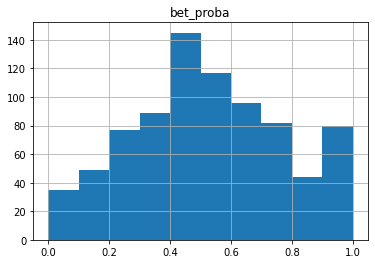

In [132]:
results_df.hist()

In [139]:
# create actual_bet column
results_df['actual_bet'] = None

# converting a probability to a bet
results_df.loc[results_df['bet_proba']>0.7,'actual_bet'] = 'WIN'
results_df.loc[results_df['bet_proba']<0.3,'actual_bet'] = 'LOSS'
results_df.loc[results_df['actual_bet'].isnull(),'actual_bet'] = 'NO BET'

results_df.head(5)

,bet_proba,actual_bet
3254,0.500024,NO BET
3255,0.467616,NO BET
3256,0.339910,NO BET
3257,0.476531,NO BET
3258,0.479467,NO BET


In [140]:
# results assessment
win_results = y_test.loc[results_df['actual_bet'] == "WIN"]
loss_results = y_test.loc[results_df['actual_bet'] == "LOSS"]
no_bet_results = y_test.loc[results_df['actual_bet'] == "NO BET"]

#print(win_results.shape[0])
#print(loss_results.shape[0])

a = y_test.loc[results_df['actual_bet'] == 'WIN'].values
b = y_test.loc[results_df['actual_bet'] == 'LOSS'].values

print(sum(a==1)*5 + sum(a==0)*-5 + sum(b==1)*-5 + sum(b==0)*5)

1125


In [141]:
# actual hackathon deliverable/output
X_final = test_csv[['gamelength','value','Kills_diff','monsters_diff','towers_diff','game_id']].set_index('game_id')

#inputs preprocessing
# initialize transformer with desired options
standardscaler = StandardScaler()
standardscaler.fit(X_final)

# fit transformer to data
X_final_scale = standardscaler.transform(X_final)

# store scaled version of features
# for some reason gives a warning
for i in range(0,X_final.shape[1]):
    X_final.loc[:,X_final.columns[i]] = X_final_scale[:,i]

# predicts probabilities
y_scores_final = pipeline.predict_proba(X_final)[:,1]

results_df_final = pd.DataFrame(y_scores_final,columns=['bet_proba']).set_index(X_final.index)

# create actual_bet column
results_df_final['bet'] = None

# converting a probability to a bet
results_df_final.loc[results_df_final['bet_proba']>0.7,'bet'] = 'WIN'
results_df_final.loc[results_df_final['bet_proba']<0.3,'bet'] = 'LOSS'
results_df_final.loc[results_df_final['bet'].isnull(),'bet'] = 'NO BET'

results_df_final = results_df_final.drop('bet_proba',axis=1)

results_df_final.head(5)

results_df_final.to_csv('submission/bets_hck02_team12.csv')

In [142]:
print(results_df_final)

                                         bet
game_id                                     
9564c32b-dad9-4292-8efb-8fa41f026fe9  NO BET
8160b53f-417a-416c-bd66-41b115e91039  NO BET
5bd6d56b-e337-4f61-83b6-cfe21a481892  NO BET
614fd189-86c9-4f44-9b13-cf980e1ccc9f  NO BET
539f6975-88f2-40ea-8d22-4b500370e971  NO BET
...                                      ...
a59e0afe-9c05-4000-9ec5-c3468f6a473b  NO BET
36ae936c-e159-49b1-96c6-3b8b877269d8  NO BET
8a2f2bb9-c899-4861-b5bb-b44e00d5a309  NO BET
b6e7e76a-60e0-4494-87c6-36a036f19353  NO BET
16d6cc6f-e923-4686-a23f-d277f65d12d9    LOSS

[3552 rows x 1 columns]
